In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve

Using TensorFlow backend.


In [2]:
# 读取数据
d = pd.read_csv('SofaSofa_Anomaly.csv')

In [3]:
# 查看样本比例 严重的样本不平衡
num_nonfraud = np.sum(d['Class'] == 0)
num_fraud = np.sum(d['Class'] == 1)
(num_nonfraud,num_fraud) 

(284315, 492)

In [4]:
# 删除时间列，对Amount进行标准化
data = d.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])

# 提取负样本，并且按照8:2切成训练集和测试集
mask = (data['Class'] == 0) # 只取正常样本
X_train, X_test = train_test_split(data[mask], test_size=0.2, random_state=32)
X_train = X_train.drop(['Class'], axis=1).values
X_test = X_test.drop(['Class'], axis=1).values

# 提取所有欺诈样本，作为测试集的一部分
X_fraud = data[~mask].drop(['Class'], axis=1).values

In [5]:
# 设置Autoencoder的参数
# 隐藏层节点数分别为16，8，16
# epoch为50，batch size为32
input_dim = X_train.shape[1]
encoding_dim = 16 # 欠完备的自编码器
num_epoch = 10
batch_size = 32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer) #第一层的encoding
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                493       
Total params: 1,253
Trainable params: 1,253
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])

In [8]:
# 模型保存为SofaSofa_model.h5，并开始训练模型
checkpointer = ModelCheckpoint(filepath="SofaSofa_model.h5",
                               verbose=0,
                               save_best_only=True)

In [9]:
# 训练
history = autoencoder.fit(X_train, X_train,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer]).history

Train on 227452 samples, validate on 56863 samples
Epoch 1/10
227452/227452 [==============================] - 18s 80us/step - loss: 0.6565 - mean_absolute_error: 0.4654 - val_loss: 0.5862 - val_mean_absolute_error: 0.4245
Epoch 2/10
227452/227452 [==============================] - 18s 81us/step - loss: 0.5850 - mean_absolute_error: 0.4198 - val_loss: 0.5698 - val_mean_absolute_error: 0.4162
Epoch 3/10
227452/227452 [==============================] - 17s 75us/step - loss: 0.5762 - mean_absolute_error: 0.4131 - val_loss: 0.5637 - val_mean_absolute_error: 0.4085
Epoch 4/10
227452/227452 [==============================] - 17s 74us/step - loss: 0.5708 - mean_absolute_error: 0.4078 - val_loss: 0.5593 - val_mean_absolute_error: 0.4062
Epoch 5/10
227452/227452 [==============================] - 17s 76us/step - loss: 0.5670 - mean_absolute_error: 0.4046 - val_loss: 0.5567 - val_mean_absolute_error: 0.4028
Epoch 6/10
227452/227452 [==============================] - 17s 73us/step - loss: 0.5628 

In [101]:
# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(122)
plt.plot(history['mean_absolute_error'], c='dodgerblue', lw=3)
plt.plot(history['val_mean_absolute_error'], c='coral', lw=3)
plt.title('model mae')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [102]:
plt.show()

In [103]:
history.keys()

dict_keys(['mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'loss'])

In [10]:
# 读取模型
autoencoder = load_model('SofaSofa_model.h5')

# 利用训练好的autoencoder重建测试集
pred_test = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)

# 计算还原误差MSE和MAE
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)

In [11]:
mse_df

Class       MSE       MAE
0          0  0.138233  0.250939
1          0  0.685391  0.622130
2          0  0.210829  0.318252
3          0  0.591718  0.465344
4          0  0.104194  0.211577
5          0  0.072992  0.212815
6          0  0.440300  0.416666
7          0  0.175767  0.355756
8          0  0.118997  0.281287
9          0  1.351106  0.778228
10         0  1.413565  0.866323
11         0  1.862281  0.963398
12         0  0.674811  0.558985
13         0  0.210944  0.338464
14         0  0.139929  0.230792
15         0  2.671411  1.016289
16         0  0.215827  0.241137
17         0  0.125259  0.244014
18         0  1.407962  0.756901
19         0  0.332917  0.419049
20         0  0.047660  0.168289
21         0  0.086420  0.242993
22         0  0.128508  0.280266
23         0  0.077673  0.230128
24         0  1.021436  0.605031
25         0  0.105818  0.232168
26         0  0.334171  0.365415
27         0  0.182406  0.325966
28         0  0.613172  0.583527
29         0  0.386958  0.385201
...      ...       ...       ...
57325      0  0.158588  0.266820
57326      0  0.155031  0.235322
57327      0  0.417912  0.470519
57328      0  0.031503  0.131537
57329      0  0.352559  0.430042
57330      0  0.292693  0.336684
57331      0  0.056766  0.186685
57332      0  0.395866  0.475572
57333      0  0.101616  0.229355
57334      0  0.078068  0.214971
57335      0  0.100598  0.242729
57336      0  0.108804  0.261080
57337      0  0.130136  0.256576
57338      0  0.327355  0.403751
57339      0  0.211584  0.352793
57340      0  0.108956  0.257335
57341      0  0.305152  0.380954
57342      0  0.152824  0.302262
57343      0  0.196614  0.315279
57344      0  0.100290  0.223971
57345      0  0.157394  0.304959
57346      0  0.224554  0.305582
57347      0  1.102511  0.854317
57348      0  0.140444  0.298355
57349      0  0.157773  0.304461
57350      0  0.108405  0.250949
57351      0  0.159400  0.286560
57352      0  0.347846  0.462161
57353      0  0.095587  0.220166
57354      0  0.489861  0.459899

[57355 rows x 3 columns]

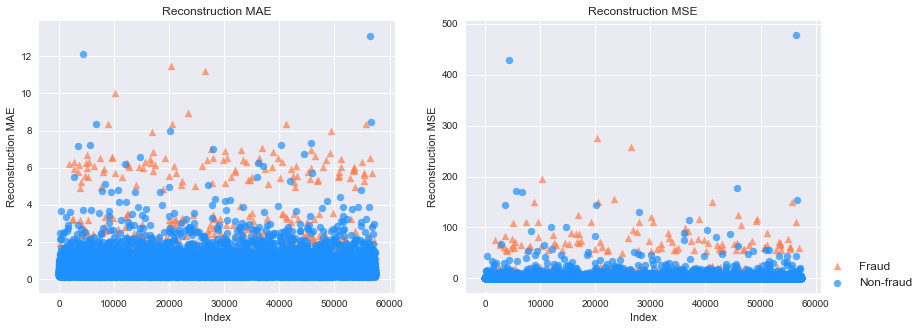

In [12]:
# 分别画出测试集中正样本和负样本的还原误差MAE和MSE
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE'); plt.xlabel('Index')
plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12); plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE'); plt.xlabel('Index')
plt.show()

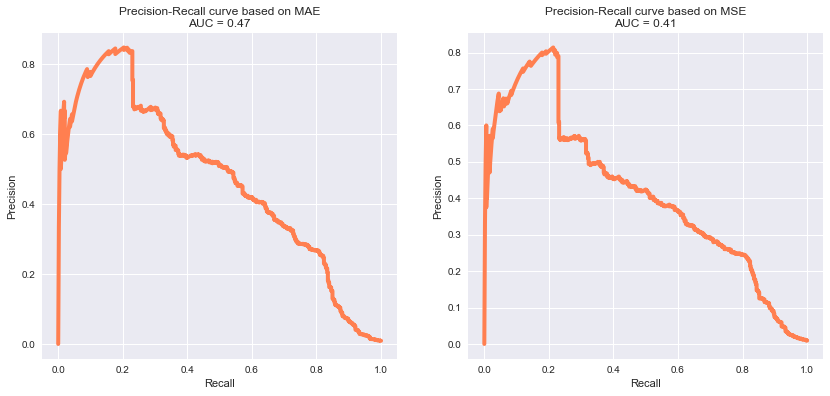

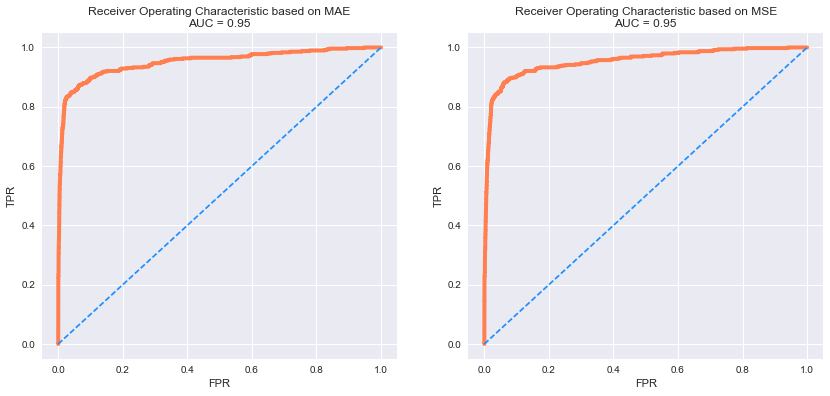

In [13]:
# 画出Precision-Recall曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    precision, recall, _ = precision_recall_curve(mse_df['Class'], mse_df[metric])
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall curve based on %s\nAUC = %0.2f'%(metric, pr_auc))
    plt.plot(recall[:-2], precision[:-2], c='coral', lw=4)
    plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()

# 画出ROC曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    fpr, tpr, _ = roc_curve(mse_df['Class'], mse_df[metric])
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic based on %s\nAUC = %0.2f'%(metric, roc_auc))
    plt.plot(fpr, tpr, c='coral', lw=4)
    plt.plot([0,1],[0,1], c='dodgerblue', ls='--')
    plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

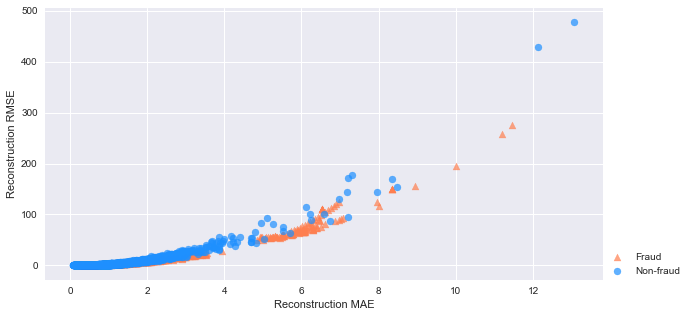

In [14]:
# 画出MSE、MAE散点图
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(10, 5))
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp['MAE'], 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0])
plt.ylabel('Reconstruction RMSE'); plt.xlabel('Reconstruction MAE')
plt.show()